In [2]:
# %load_ext autoreload
# %autoreload 2
%load_ext tuna

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import dill
import os
import seaborn as sns
import torch
import pandas as pd

from collections import namedtuple
from hmmlearn.hmm import MultinomialHMM
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from spn.algorithms.Inference import log_likelihood

# from rspnlib.models import RSPN, EMTrainingParams
# from rspnlib.models.hmm import HmmRSPN
# from rspnlib.models.iohmm import (
#     IoHmmRSPN,
#     ExtendedIoHmmRSPN,
#     ContinuousIoHmmRSPN,
#     OverparametrisedIoHmmRSPN,
#     OverparametrisedContinuousIoHmmRSPN,
#     ExtendedOverparametrisedContinuousIoHmmRSPN,
# )
# from rspnlib.evaluation import (
#     compute_metrics,
#     get_empty_metrics,
#     add_metrics,
#     print_aggregate_metrics,
#     evaluate_rspn_one_step_ahead_prediction,
#     evaluate_rspn_observation_regression,
# )
# from experiment_utils.datasets.vasopressors_dataset import load_vasopressors_dataset
from experiment_utils.datasets.mimic_continuous_dataset import load_mimic_dataset
# from experiment_utils.baselines.lstm import train_eval_lstm
# from experiment_utils.baselines.most_common_class import train_eval_most_common_baseline


from engine_dataset import generate_engine_dataset, generate_engine_datasets

from oSLRAU_run import get_data
from spn.structure.leaves.parametric.Parametric import Gaussian, Bernoulli, Categorical,  In_Latent, Multivariate_Gaussian
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_parametric
from spn.io.Graphics import plot_spn
import numpy as np
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from spn.algorithms.oSLRAU import oSLRAU, oSLRAUParams
from spn.algorithms.RSPN import RSPN
from spn.algorithms.TransformStructure import Prune ,Prune_oSLRAU

from hmmlearn import hmm
from spn.algorithms.Inference import log_likelihood

# MIMIC Experiments

In [3]:
SEQ_LENGTH = 8
NUM_STATES = 20
NUM_SEEDS = 5
SEEDS = range(42, 42 + NUM_SEEDS)

train_mimic_datasets, test_mimic_datasets = load_mimic_dataset(
    seq_length=SEQ_LENGTH,
)
num_inputs = (
    int(
        np.max(train_mimic_datasets[0].inputs_raw)
    )
    + 1
)
observations_dim = 3

  0%|          | 0/6052 [00:00<?, ?it/s]

Loaded 5967 data points
Partitioning into folds...
Done!


In [4]:
import pickle
train_mimic_datasets, test_mimic_datasets = pickle.load(open('./data_splits/data.pkl', 'rb'))
observations_dim = 3
num_inputs = 2

<h2> oSLRAU  </h2>

In [17]:
def train_rspn_mimic(train_data, test_data, epoch, rspn=None, os_args=None):

    if len(train_data.shape) == 3: train_data = np.squeeze(train_data)
    if len(test_data.shape) == 3: test_data = np.squeeze(test_data)

    if rspn is None:
    
        rspn = RSPN(num_variables=os_args["num_variables"], num_latent_variables=os_args["num_latent_variables"], num_latent_values=os_args["num_latent_values"])
        first_mini_batch = train_data[0:os_args["mini_batch_size"]]
        n = first_mini_batch.shape[1]

        print(f"n: {n}") # = num_time_steps_mix * n_dim
        
        context = [Gaussian, Gaussian, Gaussian, Bernoulli]*(int(n/4)) # Bernoulli Categorical
        ds_context = Context(parametric_types=context).add_domains(first_mini_batch[:, :os_args["num_variables"]])
        spn, initial_template_spn, top_spn = rspn.build_initial_template(first_mini_batch, ds_context, os_args["len_sequence_varies"])

    
    no_of_minibatches = int(train_data.shape[0] / os_args["mini_batch_size"])

    print(f"no of minibatches: {no_of_minibatches}")

    
    for i in range(1, no_of_minibatches):
        mini_batch = train_data[i * os_args["mini_batch_size"]: (i+1) * os_args["mini_batch_size"]]
    
        update_template = False
        
        # if (i % os_args["update_after_no_min_batches"] == 0) and (i!=0) :
        #if i % os_args["update_after_no_min_batches"] == 0 and i<=60 and epoch == 0:
        if i == 10 and epoch == 0:
            print(i)
            update_template = True

        try:
            template_spn = rspn.learn_rspn(mini_batch, update_template, os_args["os_params"], os_args["unroll"],
                                            os_args["full_update"], os_args["update_leaves"],
                                            os_args["len_sequence_varies"])
        
        except Exception:
            print(f"==>> mini_batch: {mini_batch}")
            assert 0 == 1
           
            
    test_ll = np.sum(rspn.log_likelihood(test_data, os_args["unroll"], os_args["len_sequence_varies"]))


    return test_ll, rspn, template_spn

In [18]:
def final_ll_mimic(data, num_epochs=1, do_plot_spn=True, os_args=None, split_data=False):
    ll = -np.inf
    rspn=None
    if split_data:
        train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    
    else:
        train_data, val_data = data, data
    for epoch in range(num_epochs):
        print(train_data.shape)
        
        
        epoch_ll, rspn, template_spn = train_rspn_mimic(train_data, val_data, epoch, rspn, os_args)        
        print(f"epoch_ll: {epoch_ll}")
        
        ll = epoch_ll
        del template_spn

    print(f" \n\n\n final ll: {ll}\n\n\n")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn

In [80]:
np.unique(train_mimic_datasets[0].inputs_raw)

#train_mimic_datasets[0].observations_raw_continuous.shape

array([0, 1], dtype=int32)

In [7]:
def process_ds(ds):
    raw_inputs = ds.inputs_raw
    obs_raw_cont = ds.observations_raw_continuous

    comb_ds = []
    for i in range(raw_inputs.shape[0]):
        comb_ds_i = []
        for j in range(raw_inputs.shape[1]):
             comb_ds_j = [*list(obs_raw_cont[i, j*3: (j+1)*3]), raw_inputs[i,j]]
             comb_ds_i.append(comb_ds_j)

        comb_ds.append(comb_ds_i)

    comb_ds = np.array(comb_ds)
    comb_ds = comb_ds.reshape(raw_inputs.shape[0], -1)

    return comb_ds


In [24]:
n_states = 2
n_dim = 4

num_time_steps = 8

oSLRAU_params = oSLRAUParams(mergebatch_threshold=128, corrthresh=0.1, mvmaxscope=1, equalweight=True, currVals=True)

os_args = {
    "num_variables": num_time_steps * n_dim,
    "num_latent_variables" : 2,
    "num_latent_values" : 2,
    "unroll" : "backward",
    "full_update" : False,
    "update_leaves" : True,
    "len_sequence_varies" : False,
    "mini_batch_size" : 5,
    "update_after_no_min_batches" : 20,
    "os_params": oSLRAU_params
    }

In [14]:
# log_likelihoods = []
#rspn_mimic_models = []

In [23]:
base_seed = SEEDS[0]
seed_dict = {SEEDS[i]: i for i in range(len(SEEDS))}
seed_ls = SEEDS[1:] # [SEEDS[1]]
#del rspn_mimic

for seed in seed_ls:
    i = seed_dict[seed]
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_ds, test_ds = process_ds(train_mimic_datasets[i]), process_ds(test_mimic_datasets[i])
    
    rspn_mimic = final_ll_mimic(train_ds, num_epochs=3, do_plot_spn=False, os_args=os_args)
    rspn_test_ll_mimic = np.sum(rspn_mimic.log_likelihood(test_ds, os_args["unroll"], os_args["len_sequence_varies"]))
    print(f"seed {seed}: log likelihood: {rspn_test_ll_mimic}")
    log_likelihoods.append(rspn_test_ll_mimic)
    rspn_mimic_models.append(rspn_mimic)

——————————[ Running experiment for seed 43 ]——————————
(4773, 32)
n: 32
==>> data.shape: (5, 32)
len(self.meta_types): 32
self.meta_types.values(): dict_values([<MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.REAL: 1>, <MetaType.BINARY: 2>])
len(self.meta_types.values()): 32
data[:, col]: [67. 98. 76. 67. 59.]
==>> domain_values: [59.0, 98.0]
feature_meta_type: MetaType.REAL
==>> domain_values: [59.0, 98.0]
len(self.meta

AssertionError: 

In [11]:
log_likelihoods

[-115425.16847259374]

In [95]:
# print(np.mean(log_likelihoods))
#log_likelihoods
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")

Mean: -112292.38213358184
STD: 2124.0484860972815


In [93]:
train_ds.shape

(4774, 32)

## Continuous IOHMM-RSPN

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


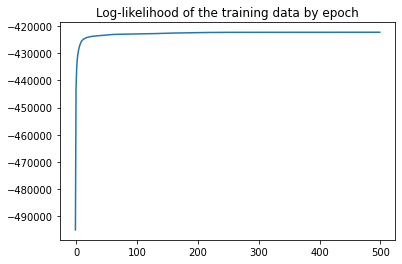

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


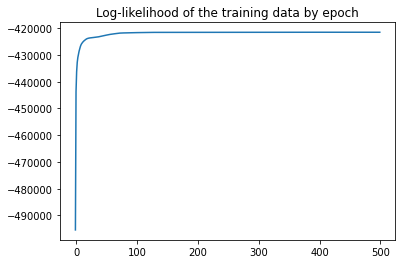

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


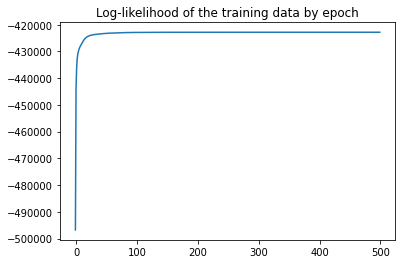

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


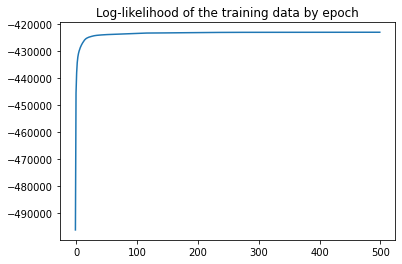

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


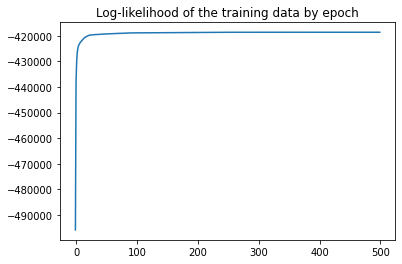

In [29]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_observations = train_mimic_datasets[i].observations_raw_continuous
    train_inputs = train_mimic_datasets[i].inputs_raw
    iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
    train_data = train_mimic_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [30]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_io_hmm_rspn_outcome_pred_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

In [31]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_io_hmm_rspn_outcome_pred_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

In [32]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -106765.52337642298
STD: 1876.2248934301335
All: [-106500.3834187034, -106944.82493398912, -105233.61484304193, -104943.48876015283, -110205.3049262277]
Median seed: 42


In [33]:
aggregate_metrics = get_empty_metrics(regression=True, num_variables=observations_dim)
for i, seed in enumerate(SEEDS):
    _, _, metrics = evaluate_rspn_observation_regression(iohmm_rspn_loaded_models[i], test_mimic_datasets[i], identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

——————————[ Running regression evaluation for seed 42 ]——————————
var 0: 10.12552654243609 (SD 0.0)
var 1: 13.362886290157988 (SD 0.0)
var 2: 4.523752258955472 (SD 0.0)
rmse: 9.33738836384985 (SD 0.0)
——————————[ Running regression evaluation for seed 43 ]——————————
var 0: 9.427844934555544 (SD 0.0)
var 1: 13.539828208973336 (SD 0.0)
var 2: 4.676513697749087 (SD 0.0)
rmse: 9.214728947092656 (SD 0.0)
——————————[ Running regression evaluation for seed 44 ]——————————
var 0: 9.568474313344089 (SD 0.0)
var 1: 12.202589845095687 (SD 0.0)
var 2: 4.480725749520501 (SD 0.0)
rmse: 8.75059663598676 (SD 0.0)
——————————[ Running regression evaluation for seed 45 ]——————————
var 0: 9.222288126339889 (SD 0.0)
var 1: 12.633730551518266 (SD 0.0)
var 2: 4.280542348186283 (SD 0.0)
rmse: 8.712187008681479 (SD 0.0)
——————————[ Running regression evaluation for seed 46 ]——————————
var 0: 9.77237665010283 (SD 0.0)
var 1: 13.616280121741475 (SD 0.0)
var 2: 4.556023984426515 (SD 0.0)
rmse: 9.314893585423606 (S

In [34]:
print("——————————[ IOHMM-RSPN regression performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

——————————[ IOHMM-RSPN regression performance ]——————————
var 0: 9.623302113355688 (SD 0.3086986909115234)
var 1: 13.071063003497352 (SD 0.5563575567828637)
var 2: 4.503511607767573 (SD 0.1290979805071613)
rmse: 9.06595890820687 (SD 0.27654398095614297)


## Continuous Treatment-RSPN with Structure Learning

In [9]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

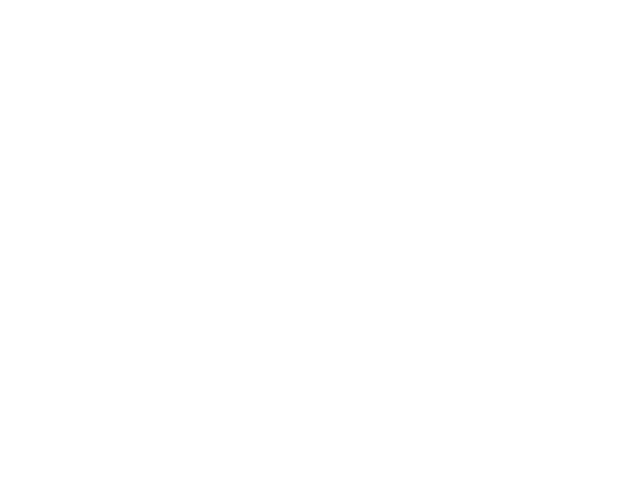

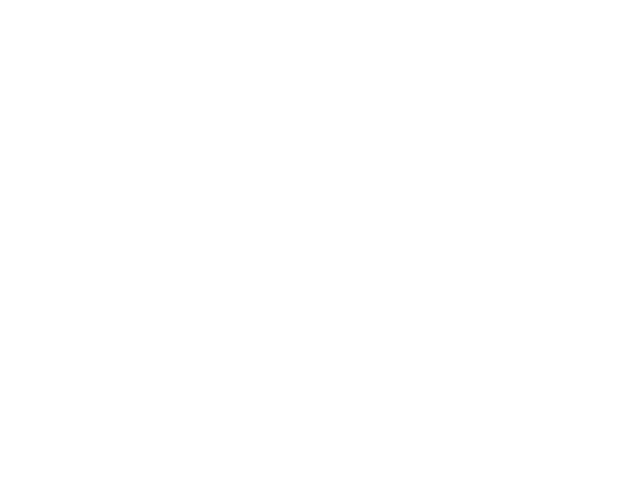

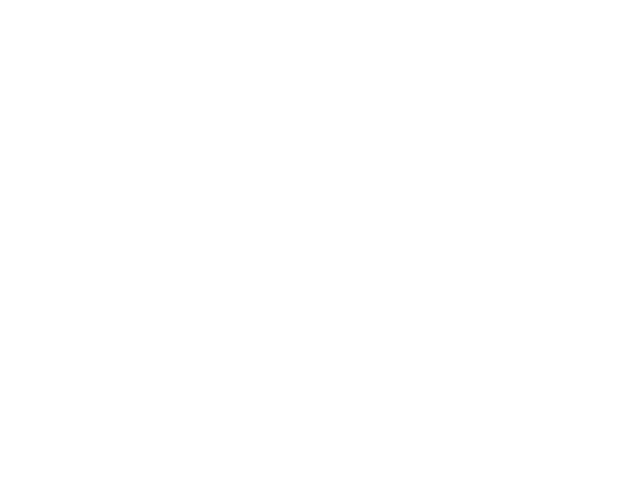

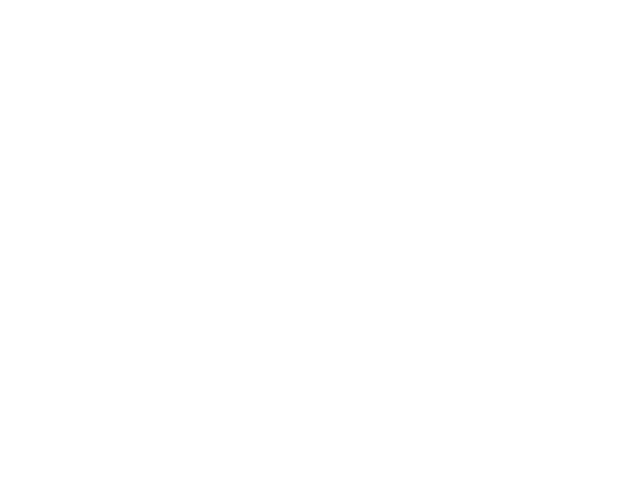

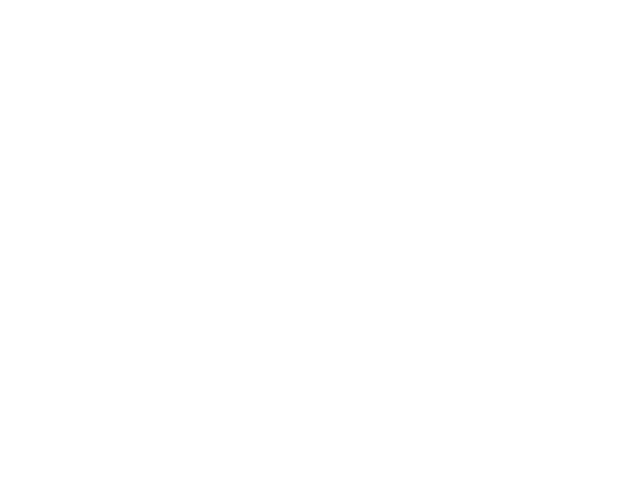

In [10]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


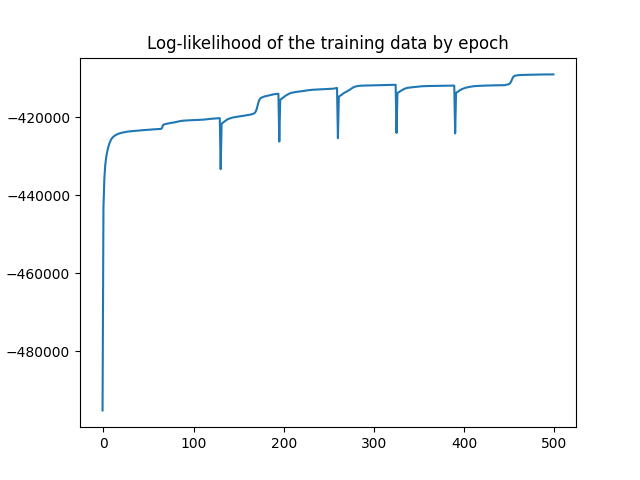

Test log-likelihood: -104127.61935215678
——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


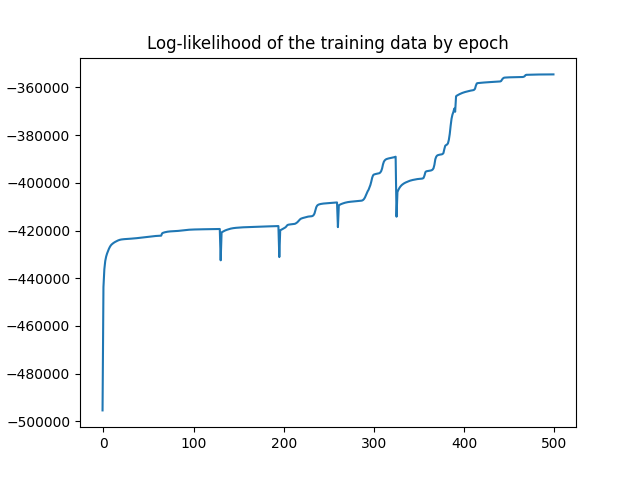

Test log-likelihood: -92060.76501219155
——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


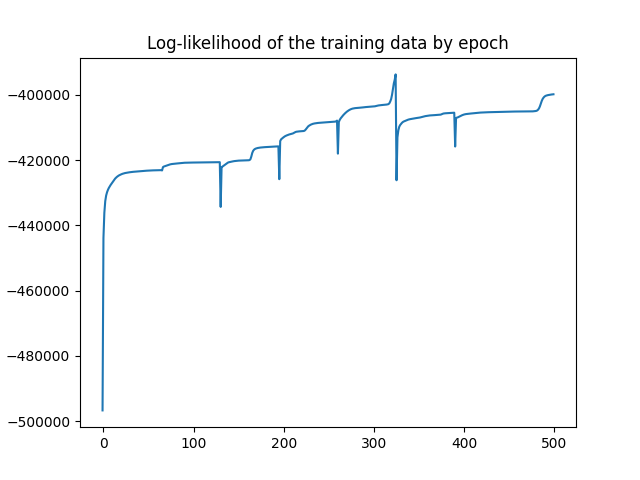

Test log-likelihood: -98053.89706814935
——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


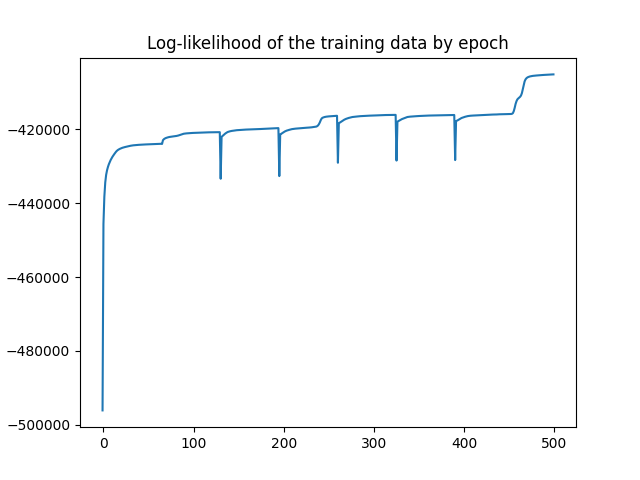

Test log-likelihood: -101179.2003408595
——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


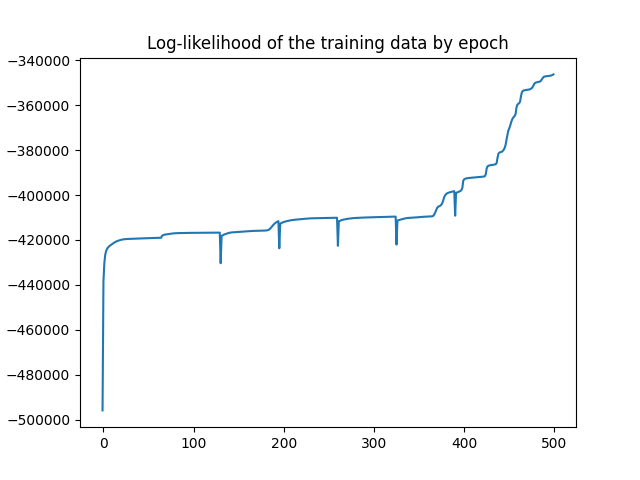

Test log-likelihood: -95807.19061496574


In [11]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/continuous_treatment_rspn_mimic_structure_train_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [12]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -98245.73447766458
STD: 4181.840185806708
All: [-104127.61935215678, -92060.76501219155, -98053.89706814935, -101179.2003408595, -95807.19061496574]
Median seed: 44


In [13]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [14]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [15]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -98245.73447766458
STD: 4181.840185806708
All: [-104127.61935215678, -92060.76501219155, -98053.89706814935, -101179.2003408595, -95807.19061496574]
Median seed: 44


## Treatment-RSPN with Structure Learning — higher NUM_STATES

In [6]:
NUM_STATES = 40

In [7]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

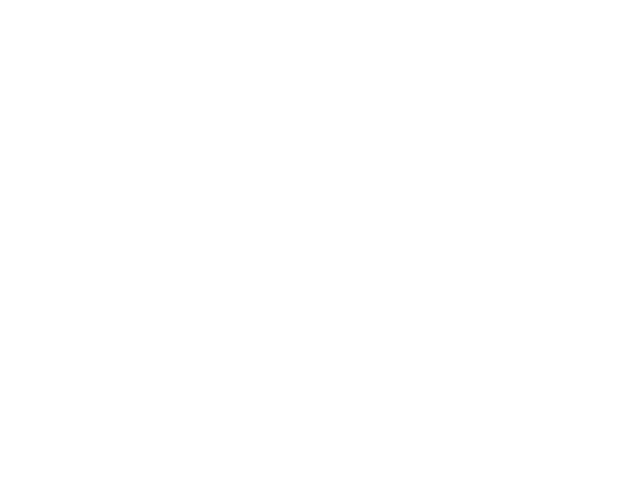

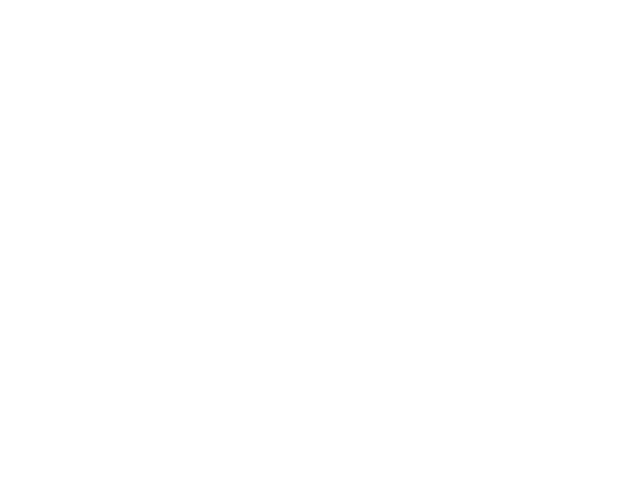

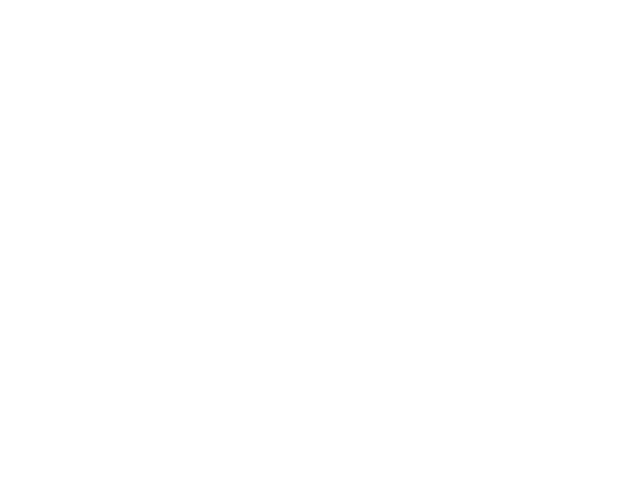

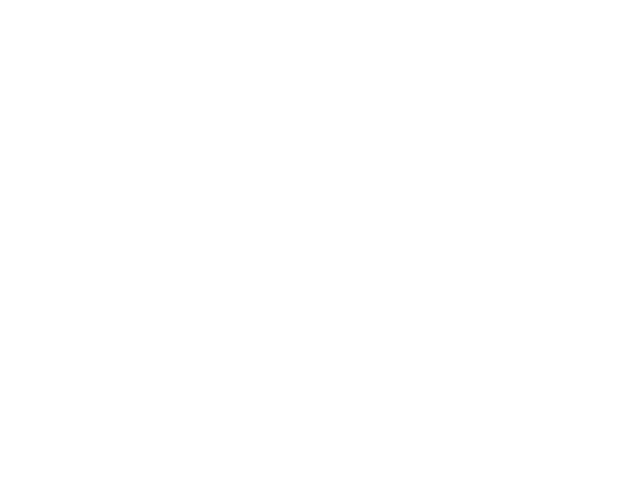

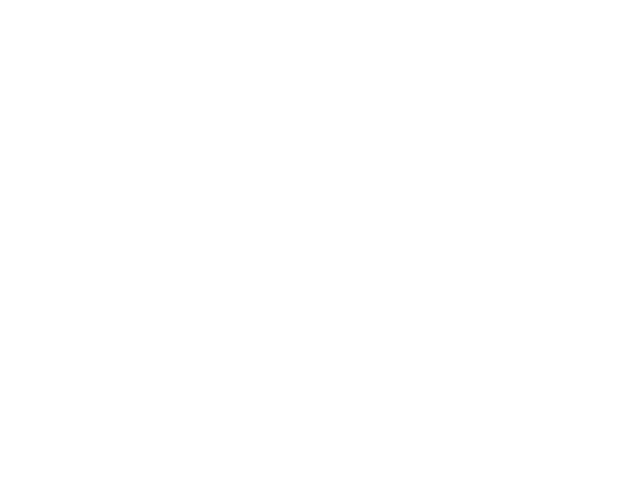

In [8]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -333686.34542190353 (AVG: -69.91123935091211)


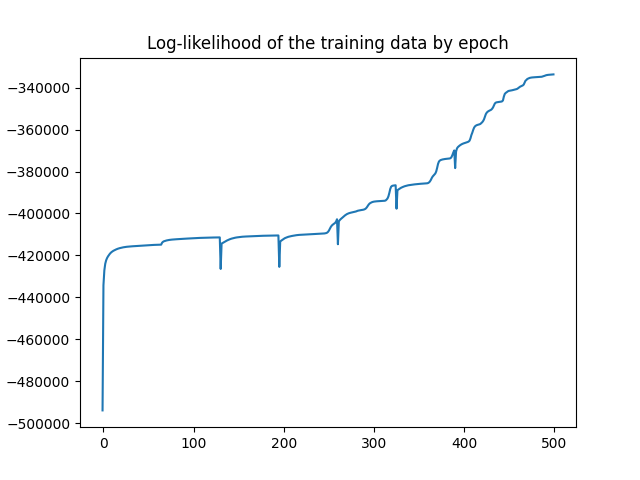

Test log-likelihood: -84885.3506883174
——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -342392.6251262658 (AVG: -71.73530800885518)


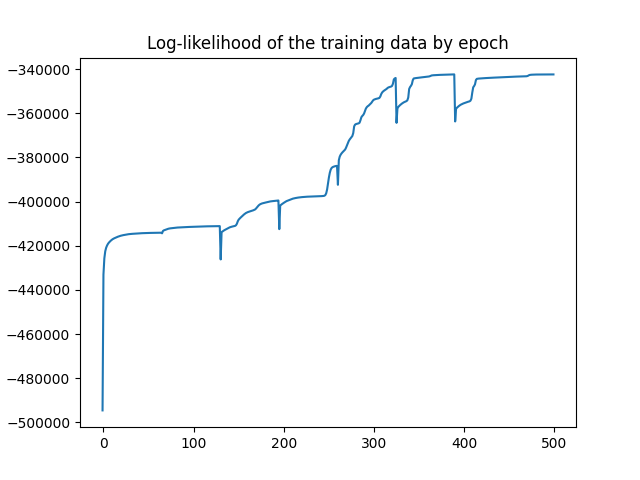

Test log-likelihood: -90015.4292836729
——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -400358.63627258275 (AVG: -83.86230336669098)


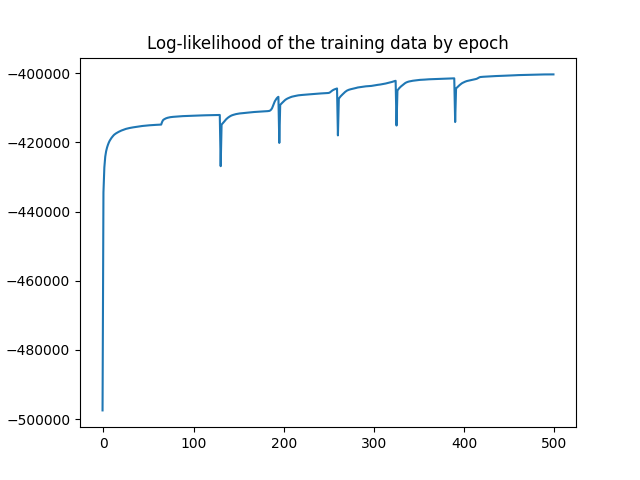

Test log-likelihood: -101969.7175988995
——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -404463.6928093717 (AVG: -84.72218114984744)


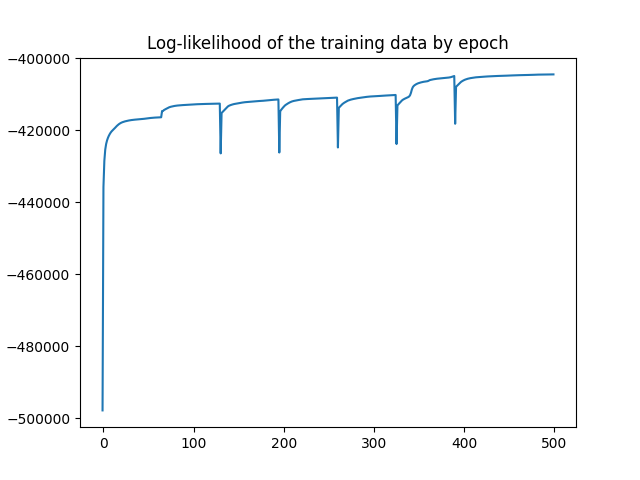

Test log-likelihood: -102417.21472392388
——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -330794.4550870139 (AVG: -69.29083684269249)


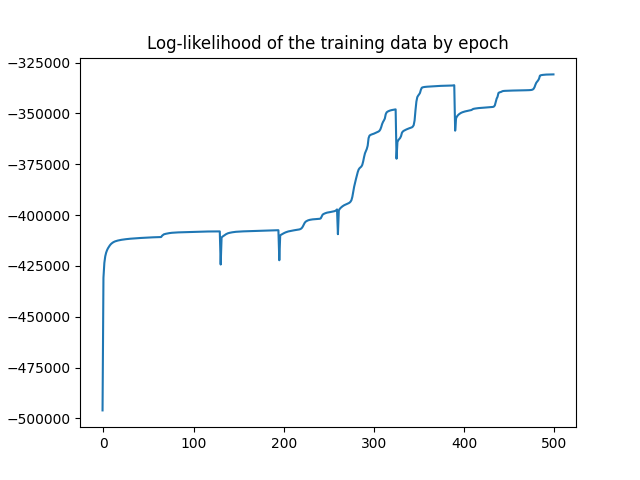

Test log-likelihood: -94783.39605825374


In [9]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/continuous_treatment_rspn_mimic_structure_train_40_states_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_40_states_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [10]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -94814.22167061348
STD: 6791.442599666458
All: [-84885.3506883174, -90015.4292836729, -101969.7175988995, -102417.21472392388, -94783.39605825374]
Median seed: 46


In [11]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_40_states_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [12]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_40_states_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [13]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -94814.22167061348
STD: 6791.442599666458
All: [-84885.3506883174, -90015.4292836729, -101969.7175988995, -102417.21472392388, -94783.39605825374]
Median seed: 46


## Overparameterised Continuous Treatment-RSPN with Structure Learning

In [19]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

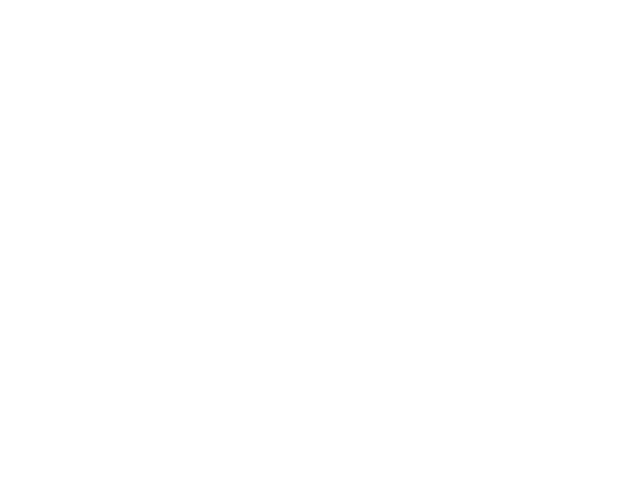

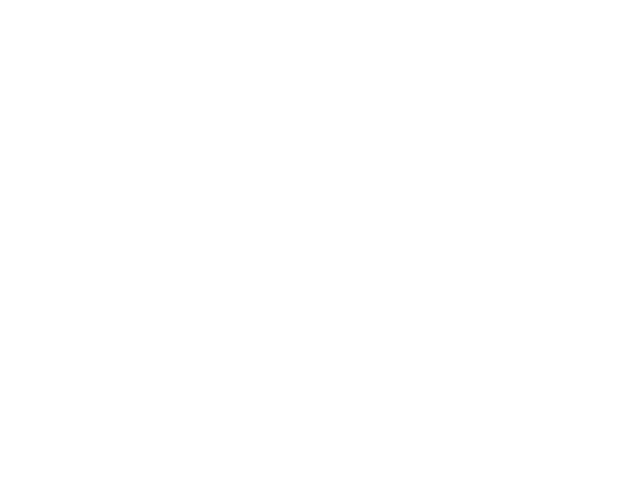

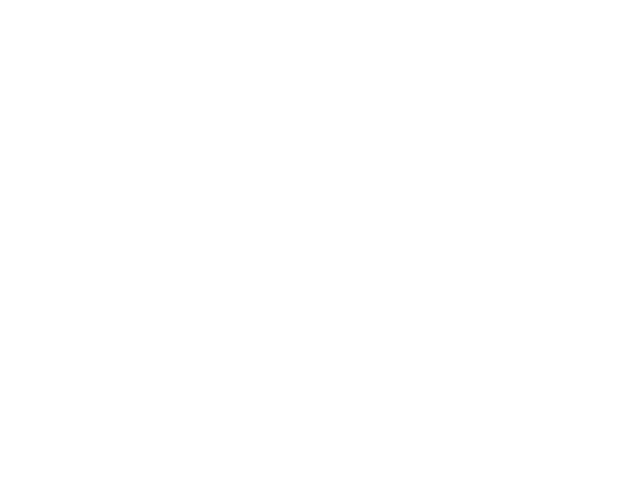

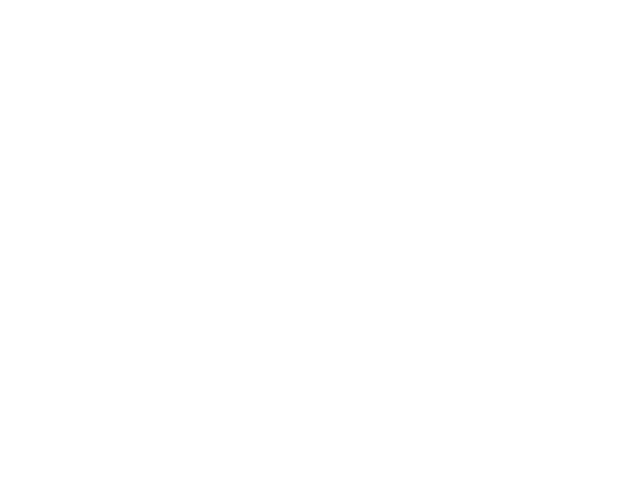

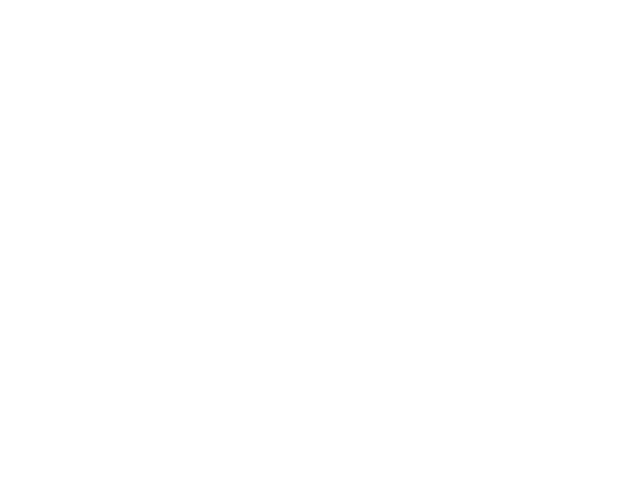

In [20]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -336410.1122568997 (AVG: -70.4819007452126)


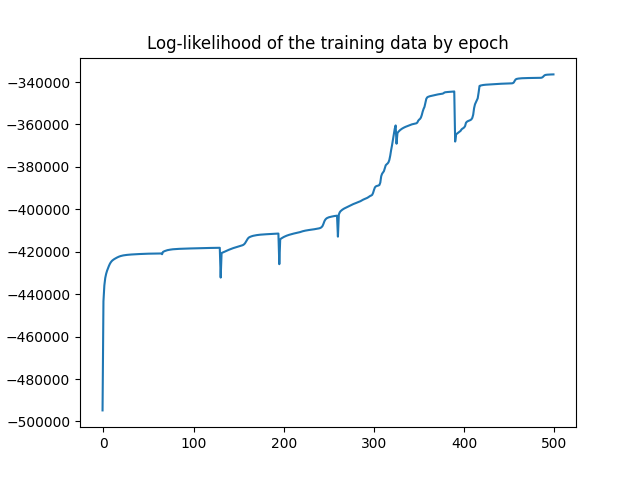

Test log-likelihood: -85368.80076299378
——————————[ Running experiment for seed 43 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -334708.2649568437 (AVG: -70.12534359037161)


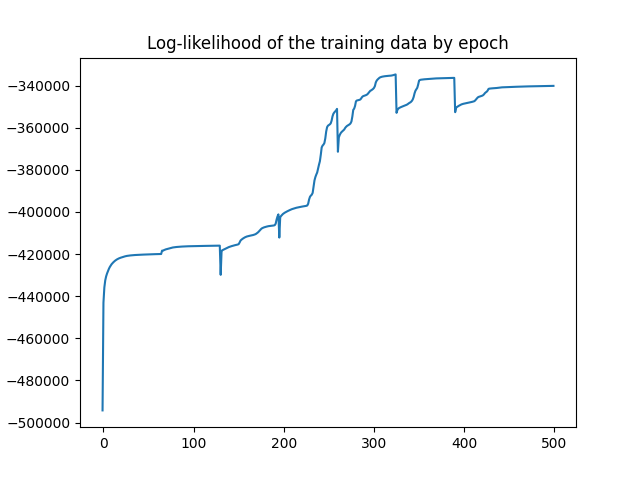

Test log-likelihood: -87212.76245521971
——————————[ Running experiment for seed 44 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -342265.70904183603 (AVG: -71.69369690863763)


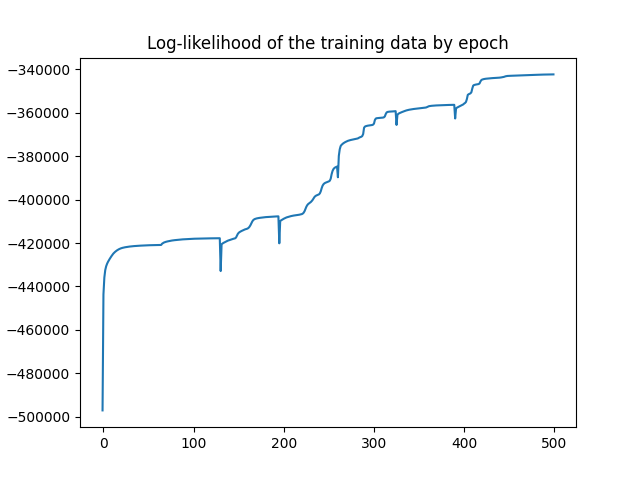

Test log-likelihood: -85163.00106178311
——————————[ Running experiment for seed 45 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -339021.0814968158 (AVG: -71.01405142371507)


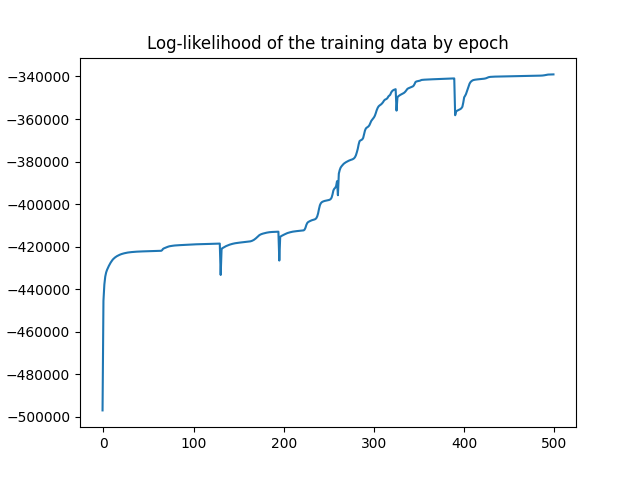

Test log-likelihood: -84823.34341510208
——————————[ Running experiment for seed 46 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -330476.74766467337 (AVG: -69.22428731978914)


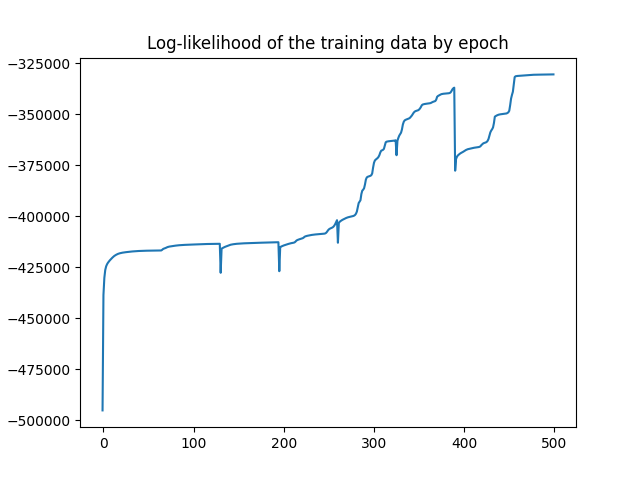

Test log-likelihood: -94144.33038251623


In [23]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_train_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = OverparametrisedContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [24]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -87342.44761552298
STD: 3500.6737228255893
All: [-85368.80076299378, -87212.76245521971, -85163.00106178311, -84823.34341510208, -94144.33038251623]
Median seed: 42


In [25]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [26]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [27]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -87342.44761552298
STD: 3500.6737228255893
All: [-85368.80076299378, -87212.76245521971, -85163.00106178311, -84823.34341510208, -94144.33038251623]
Median seed: 42


## Profiling

In [13]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=5,
    structure_learning_final_pause=1,
    num_epochs=10,
)

In [14]:
train_observations = train_mimic_datasets[0].observations_raw_continuous
train_inputs = train_mimic_datasets[0].inputs_raw
iohmm_rspn = OverparametrisedContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, 42, 2)
train_data = train_mimic_datasets[0].spn_data_continuous

Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/10 [00:00<?, ?it/s]

Training complete.
Best likelihood: -424027.3357600821 (AVG: -88.83874623089925)


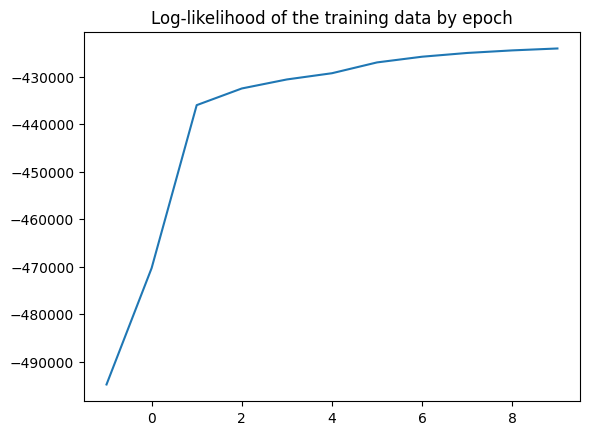

In [15]:
# %%tuna
iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params)

## LSTM Continuous Outcome Prediction

In [ ]:
aggregate_metrics = get_empty_metrics(regression=True, num_variables=observations_dim)
for i, seed in enumerate(SEEDS):
    _, _, metrics = train_eval_lstm(
        train_mimic_datasets[i], 
        test_mimic_datasets[i],
        num_inputs,
        observations_dim,
        seed,
        action_prediction=False,
        continuous=True
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ LSTM regression performance ]——————————")
print_aggregate_metrics(aggregate_metrics)